In [0]:
#!pip install -U yellowbrick

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
%%time
data = pd.read_csv('/content/drive/My Drive/Data/features.csv')
data['Date'] = pd.to_datetime(data['Date'].apply(lambda x: x.split()[0]))

CPU times: user 4.76 s, sys: 443 ms, total: 5.2 s
Wall time: 5.5 s


In [4]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Cardnum_Merchnum,Cardnum_Merch zip,Cardnum_Merch state,Amount_Cardnum_mean_0d,Actual_Amount/Cardnum_mean_0d,Amount_Cardnum_max_0d,Actual_Amount/Cardnum_max_0d,Amount_Cardnum_median_0d,Actual_Amount/Cardnum_median_0d,Amount_Cardnum_sum_0d,Actual_Amount/Cardnum_sum_0d,Cardnum_count_0d,Amount_Cardnum_mean_1d,Actual_Amount/Cardnum_mean_1d,Amount_Cardnum_max_1d,Actual_Amount/Cardnum_max_1d,Amount_Cardnum_median_1d,Actual_Amount/Cardnum_median_1d,Amount_Cardnum_sum_1d,Actual_Amount/Cardnum_sum_1d,Cardnum_count_1d,Amount_Cardnum_mean_3d,Actual_Amount/Cardnum_mean_3d,Amount_Cardnum_max_3d,Actual_Amount/Cardnum_max_3d,Amount_Cardnum_median_3d,Actual_Amount/Cardnum_median_3d,Amount_Cardnum_sum_3d,Actual_Amount/Cardnum_sum_3d,Cardnum_count_3d,Amount_Cardnum_mean_7d,Actual_Amount/Cardnum_mean_7d,Amount_Cardnum_max_7d,Actual_Amount/Cardnum_max_7d,Amount_Cardnum_median_7d,Actual_Amount/Cardnum_median_7d,Amount_Cardnum_sum_7d,Actual_Amount/Cardnum_sum_7d,Cardnum_count_7d,Amount_Cardnum_mean_14d,Actual_Amount/Cardnum_mean_14d,Amount_Cardnum_max_14d,Actual_Amount/Cardnum_max_14d,Amount_Cardnum_median_14d,Actual_Amount/Cardnum_median_14d,Amount_Cardnum_sum_14d,Actual_Amount/Cardnum_sum_14d,Cardnum_count_14d,Amount_Cardnum_mean_30d,Actual_Amount/Cardnum_mean_30d,Amount_Cardnum_max_30d,Actual_Amount/Cardnum_max_30d,Amount_Cardnum_median_30d,Actual_Amount/Cardnum_median_30d,Amount_Cardnum_sum_30d,Actual_Amount/Cardnum_sum_30d,Cardnum_count_30d,Days_since_Cardnum,Amount_Merchnum_mean_0d,Actual_Amount/Merchnum_mean_0d,Amount_Merchnum_max_0d,Actual_Amount/Merchnum_max_0d,Amount_Merchnum_median_0d,Actual_Amount/Merchnum_median_0d,Amount_Merchnum_sum_0d,Actual_Amount/Merchnum_sum_0d,Merchnum_count_0d,Amount_Merchnum_mean_1d,Actual_Amount/Merchnum_mean_1d,Amount_Merchnum_max_1d,Actual_Amount/Merchnum_max_1d,Amount_Merchnum_median_1d,Actual_Amount/Merchnum_median_1d,Amount_Merchnum_sum_1d,Actual_Amount/Merchnum_sum_1d,Merchnum_count_1d,Amount_Merchnum_mean_3d,Actual_Amount/Merchnum_mean_3d,Amount_Merchnum_max_3d,Actual_Amount/Merchnum_max_3d,Amount_Merchnum_median_3d,Actual_Amount/Merchnum_median_3d,Amount_Merchnum_sum_3d,Actual_Amount/Merchnum_sum_3d,Merchnum_count_3d,Amount_Merchnum_mean_7d,Actual_Amount/Merchnum_mean_7d,Amount_Merchnum_max_7d,Actual_Amount/Merchnum_max_7d,Amount_Merchnum_median_7d,Actual_Amount/Merchnum_median_7d,Amount_Merchnum_sum_7d,Actual_Amount/Merchnum_sum_7d,Merchnum_count_7d,Amount_Merchnum_mean_14d,Actual_Amount/Merchnum_mean_14d,Amount_Merchnum_max_14d,Actual_Amount/Merchnum_max_14d,Amount_Merchnum_median_14d,Actual_Amount/Merchnum_median_14d,Amount_Merchnum_sum_14d,Actual_Amount/Merchnum_sum_14d,Merchnum_count_14d,Amount_Merchnum_mean_30d,Actual_Amount/Merchnum_mean_30d,Amount_Merchnum_max_30d,Actual_Amount/Merchnum_max_30d,Amount_Merchnum_median_30d,Actual_Amount/Merchnum_median_30d,Amount_Merchnum_sum_30d,Actual_Amount/Merchnum_sum_30d,Merchnum_count_30d,Days_since_Merchnum,Amount_Cardnum_Merchnum_mean_0d,Actual_Amount/Cardnum_Merchnum_mean_0d,Amount_Cardnum_Merchnum_max_0d,Actual_Amount/Cardnum_Merchnum_max_0d,Amount_Cardnum_Merchnum_median_0d,Actual_Amount/Cardnum_Merchnum_median_0d,Amount_Cardnum_Merchnum_sum_0d,Actual_Amount/Cardnum_Merchnum_sum_0d,Cardnum_Merchnum_count_0d,Amount_Cardnum_Merchnum_mean_1d,Actual_Amount/Cardnum_Merchnum_mean_1d,Amount_Cardnum_Merchnum_max_1d,Actual_Amount/Cardnum_Merchnum_max_1d,Amount_Cardnum_Merchnum_median_1d,Actual_Amount/Cardnum_Merchnum_median_1d,Amount_Cardnum_Merchnum_sum_1d,Actual_Amount/Cardnum_Merchnum_sum_1d,Cardnum_Merchnum_count_1d,Amount_Cardnum_Merchnum_mean_3d,Actual_Amount/Cardnum_Merchnum_mean_3d,Amount_Cardnum_Merchnum_max_3d,Actual_Amount/Cardnum_Merchnum_max_3d,Amount_Cardnum_Merchnum_median_3d,Actual_Amount/Cardnum_Merchnum_median_3d,Amount_Cardnum_Merchnum_sum_3d,Actual_Amount/Cardnum_Merchnum_sum_3d,Cardnum_Merchnum_count_3d,Amount_Cardnum_Merchnum_mean_7d,Actual_Amount

In [5]:
%%time
for key in data.columns:
    if 'Days' in key:
        data[key] = data[key].apply(round)

CPU times: user 395 ms, sys: 89.9 ms, total: 485 ms
Wall time: 490 ms


In [0]:
data = data.drop(columns = ['Recnum', 'Cardnum', 'Merchnum', 'Merch description', 'Merch state', 'Merch zip', 'Transtype',
                            'Cardnum_Merchnum', 'Cardnum_Merch zip', 'Cardnum_Merch state'])

In [7]:
data.head()

,Date,Amount,Fraud,Amount_Cardnum_mean_0d,Actual_Amount/Cardnum_mean_0d,Amount_Cardnum_max_0d,Actual_Amount/Cardnum_max_0d,Amount_Cardnum_median_0d,Actual_Amount/Cardnum_median_0d,Amount_Cardnum_sum_0d,Actual_Amount/Cardnum_sum_0d,Cardnum_count_0d,Amount_Cardnum_mean_1d,Actual_Amount/Cardnum_mean_1d,Amount_Cardnum_max_1d,Actual_Amount/Cardnum_max_1d,Amount_Cardnum_median_1d,Actual_Amount/Cardnum_median_1d,Amount_Cardnum_sum_1d,Actual_Amount/Cardnum_sum_1d,Cardnum_count_1d,Amount_Cardnum_mean_3d,Actual_Amount/Cardnum_mean_3d,Amount_Cardnum_max_3d,Actual_Amount/Cardnum_max_3d,Amount_Cardnum_median_3d,Actual_Amount/Cardnum_median_3d,Amount_Cardnum_sum_3d,Actual_Amount/Cardnum_sum_3d,Cardnum_count_3d,Amount_Cardnum_mean_7d,Actual_Amount/Cardnum_mean_7d,Amount_Cardnum_max_7d,Actual_Amount/Cardnum_max_7d,Amount_Cardnum_median_7d,Actual_Amount/Cardnum_median_7d,Amount_Cardnum_sum_7d,Actual_Amount/Cardnum_sum_7d,Cardnum_count_7d,Amount_Cardnum_mean_14d,Actual_Amount/Cardnum_mean_14d,Amount_Cardnum_max_14d,Actual_Amount/Cardnum_max_14d,Amount_Cardnum_median_14d,Actual_Amount/Cardnum_median_14d,Amount_Cardnum_sum_14d,Actual_Amount/Cardnum_sum_14d,Cardnum_count_14d,Amount_Cardnum_mean_30d,Actual_Amount/Cardnum_mean_30d,Amount_Cardnum_max_30d,Actual_Amount/Cardnum_max_30d,Amount_Cardnum_median_30d,Actual_Amount/Cardnum_median_30d,Amount_Cardnum_sum_30d,Actual_Amount/Cardnum_sum_30d,Cardnum_count_30d,Days_since_Cardnum,Amount_Merchnum_mean_0d,Actual_Amount/Merchnum_mean_0d,Amount_Merchnum_max_0d,Actual_Amount/Merchnum_max_0d,Amount_Merchnum_median_0d,Actual_Amount/Merchnum_median_0d,Amount_Merchnum_sum_0d,Actual_Amount/Merchnum_sum_0d,Merchnum_count_0d,Amount_Merchnum_mean_1d,Actual_Amount/Merchnum_mean_1d,Amount_Merchnum_max_1d,Actual_Amount/Merchnum_max_1d,Amount_Merchnum_median_1d,Actual_Amount/Merchnum_median_1d,Amount_Merchnum_sum_1d,Actual_Amount/Merchnum_sum_1d,Merchnum_count_1d,Amount_Merchnum_mean_3d,Actual_Amount/Merchnum_mean_3d,Amount_Merchnum_max_3d,Actual_Amount/Merchnum_max_3d,Amount_Merchnum_median_3d,Actual_Amount/Merchnum_median_3d,Amount_Merchnum_sum_3d,Actual_Amount/Merchnum_sum_3d,Merchnum_count_3d,Amount_Merchnum_mean_7d,Actual_Amount/Merchnum_mean_7d,Amount_Merchnum_max_7d,Actual_Amount/Merchnum_max_7d,Amount_Merchnum_median_7d,Actual_Amount/Merchnum_median_7d,Amount_Merchnum_sum_7d,Actual_Amount/Merchnum_sum_7d,Merchnum_count_7d,Amount_Merchnum_mean_14d,Actual_Amount/Merchnum_mean_14d,Amount_Merchnum_max_14d,Actual_Amount/Merchnum_max_14d,Amount_Merchnum_median_14d,Actual_Amount/Merchnum_median_14d,Amount_Merchnum_sum_14d,Actual_Amount/Merchnum_sum_14d,Merchnum_count_14d,Amount_Merchnum_mean_30d,Actual_Amount/Merchnum_mean_30d,Amount_Merchnum_max_30d,Actual_Amount/Merchnum_max_30d,Amount_Merchnum_median_30d,Actual_Amount/Merchnum_median_30d,Amount_Merchnum_sum_30d,Actual_Amount/Merchnum_sum_30d,Merchnum_count_30d,Days_since_Merchnum,Amount_Cardnum_Merchnum_mean_0d,Actual_Amount/Cardnum_Merchnum_mean_0d,Amount_Cardnum_Merchnum_max_0d,Actual_Amount/Cardnum_Merchnum_max_0d,Amount_Cardnum_Merchnum_median_0d,Actual_Amount/Cardnum_Merchnum_median_0d,Amount_Cardnum_Merchnum_sum_0d,Actual_Amount/Cardnum_Merchnum_sum_0d,Cardnum_Merchnum_count_0d,Amount_Cardnum_Merchnum_mean_1d,Actual_Amount/Cardnum_Merchnum_mean_1d,Amount_Cardnum_Merchnum_max_1d,Actual_Amount/Cardnum_Merchnum_max_1d,Amount_Cardnum_Merchnum_median_1d,Actual_Amount/Cardnum_Merchnum_median_1d,Amount_Cardnum_Merchnum_sum_1d,Actual_Amount/Cardnum_Merchnum_sum_1d,Cardnum_Merchnum_count_1d,Amount_Cardnum_Merchnum_mean_3d,Actual_Amount/Cardnum_Merchnum_mean_3d,Amount_Cardnum_Merchnum_max_3d,Actual_Amount/Cardnum_Merchnum_max_3d,Amount_Cardnum_Merchnum_median_3d,Actual_Amount/Cardnum_Merchnum_median_3d,Amount_Cardnum_Merchnum_sum_3d,Actual_Amount/Cardnum_Merchnum_sum_3d,Cardnum_Merchnum_count_3d,Amount_Cardnum_Merchnum_mean_7d,Actual_Amount/Cardnum_Merchnum_mean_7d,Amount_Cardnum_Merchnum_max_7d,Actual_Amount/Cardnum_Merchnum_max_7d,Amount_Cardnum_Merchnum_median_7d,

In [0]:
data = data[data['Date'] > pd.to_datetime('2010-01-14')]
train = data[data['Date'] <= pd.to_datetime('2020-10-31')].copy()

In [0]:
X = train.drop(columns=['Fraud', 'Date'])
y = train['Fraud']

In [0]:
def calculate_fdr(y_true, y_pred):
    tot = y_true.sum()
    pos = y_true[y_pred.argsort()[::-1]][:int(len(y_true) * 0.03)].sum()
    return pos / tot *100

In [0]:
fdr_scorer = make_scorer(calculate_fdr, needs_proba = True)

In [0]:
rfe = RFECV(xgb.XGBRFClassifier(tree_method = 'gpu_hist'), verbose = 2, min_features_to_select = 30,
            cv = TimeSeriesSplit(n_splits = 5), scoring = fdr_scorer)

In [13]:
%%time
rfe.fit(X, y)

Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
Fitting estimator with 319 features.
Fitting estimator with 318 features.
Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
F

RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1,
                                colsample_bynode=0.8, colsample_bytree=1,
                                gamma=0, learning_rate=1, max_delta_step=0,
                                max_depth=3, min_child_weight=1, missing=None,
                                n_estimators=100, n_jobs=1, nthread=None,
                                objective='binary:logistic', random_state=0,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                seed=None, silent=None, subsample=0.8,
                                tree_method='gpu_hist', verbosity=1),
      min_features_to_select=30, n_jobs=None,
      scoring=make_scorer(calculate_fdr, needs_proba=True), step=1, verbose=2)

In [0]:
n = 30 # to select top 6 features
feature_ranks = rfe.ranking_  # selector is a RFECV fitted object
feature_ranks_with_idx = enumerate(feature_ranks)
sorted_ranks_with_idx = sorted(feature_ranks_with_idx, key=lambda x: x[1])
top_n_idx = [idx for idx, rnk in sorted_ranks_with_idx[:n]]

In [0]:
sel = X.iloc[:,top_n_idx].columns.tolist()

In [35]:
len(sel)

30

In [36]:
sel

['Amount_Cardnum_median_1d',
 'Actual_Amount/Cardnum_median_1d',
 'Amount_Cardnum_sum_1d',
 'Actual_Amount/Cardnum_sum_1d',
 'Cardnum_count_1d',
 'Amount_Cardnum_mean_3d',
 'Actual_Amount/Cardnum_mean_3d',
 'Amount_Cardnum_max_3d',
 'Actual_Amount/Cardnum_max_3d',
 'Amount_Cardnum_median_3d',
 'Actual_Amount/Cardnum_median_3d',
 'Amount_Cardnum_sum_3d',
 'Actual_Amount/Cardnum_sum_3d',
 'Cardnum_count_3d',
 'Amount_Cardnum_mean_7d',
 'Actual_Amount/Cardnum_mean_7d',
 'Amount_Cardnum_max_7d',
 'Actual_Amount/Cardnum_max_7d',
 'Amount_Cardnum_median_7d',
 'Actual_Amount/Cardnum_median_7d',
 'Amount_Cardnum_sum_7d',
 'Actual_Amount/Cardnum_sum_7d',
 'Cardnum_count_7d',
 'Amount_Cardnum_mean_14d',
 'Actual_Amount/Cardnum_mean_14d',
 'Amount_Cardnum_max_14d',
 'Actual_Amount/Cardnum_max_14d',
 'Amount_Cardnum_median_14d',
 'Actual_Amount/Cardnum_median_14d',
 'Amount_Cardnum_sum_14d']

In [0]:
X = X[sel]

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


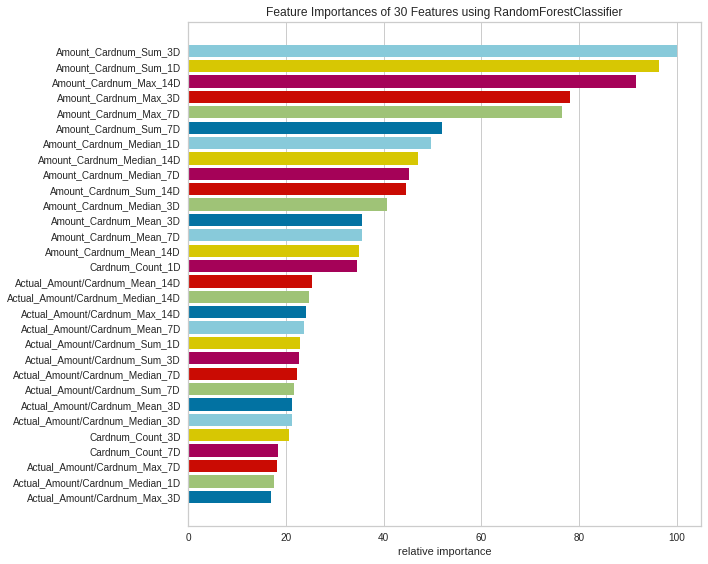

In [38]:
plt.figure(figsize=(10,8))
ax = plt.gca()
labels = list(map(lambda s: s.title(), X.columns))
viz = FeatureImportances(RandomForestClassifier(n_jobs = -1), labels=labels, relative=True)
viz.fit(X, y)
viz.show(ax=ax)